# El Aprendizaje con Clases Desbalanceadas

En el aprendizaje supervisado se considera que un conjunto de entrenamiento de dos clases está desbalanceado cuando el número de muestras de una de las clases (la clase mayoritaria) sobrepasa el número de muestras de la otra (la clase minoritaria).

En este Notebook se busca evidenciar como los clasificadores pueden estar sesgados cuando se entrenan con un conjunto de datos desbalanceados. Adicionalmente, usaremos algunos de los métodos de muestreo para abordar este problema y veremos cuál es su impacto en la distribución de las clases y en la construcción de las fronteras de decisión de un clasificador.

In [1]:
#Iniciamos importando las librerías básicas a utilizar
%matplotlib inline
import numpy as np    #Biblioteca para el manejo de arreglos y matrices en Python
import seaborn as sns #Biblioteca para la visualización de conjunto de datos de tipo DataFrame
import pandas as pd   #Biblioteca para la manipulación de conjuntos de datos, en nuestro caso DataFrames
import imblearn       #Biblioteca para balanceo de clases

import matplotlib
from matplotlib import pyplot as plt    #Clase para la genearación de gráficos
from sklearn.datasets import make_blobs #Clase para crear conjuntos de datos basados en Gaussianas

## 1. Evidenciando el problema

Para evidenciar el problema, vamos a crear dos conjuntos de datos de juguete (toy dataset) a partir de dos Gaussianas en 2D (una por clase). En el conjunto de datos desbalaceado (X_des), la primera clase tiene 100 instancias y la segunda 900; es decir, el conjunto está desbalanceado y la clase minoritaria tiene una proporción de 1/10, respecto al conjunto de datos completo. El otro conjunto (X_blc) está balaceado y tiene 1000 instancias en cada clase.

Text(0.5,1,'Conjuntos de datos Desbalanceado')

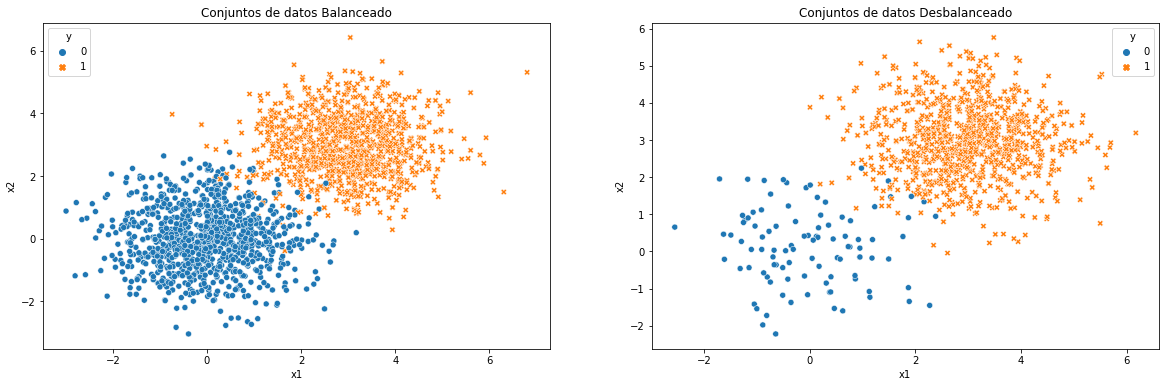

In [2]:
#Creamos dos Gaussianas - Una con centro (0,0) y otra con centro (3,3)
X_des, y_des = make_blobs(n_samples=[100, 900], centers=[(0, 0), (3, 3)], n_features=[2, 2], random_state=0)
X_blc, y_blc = make_blobs(n_samples=[1000, 1000], centers=[(0, 0), (3, 3)], n_features=[2, 2], random_state=0)

# Craemos un DataFrame a partir de los datos para visualizarlos rápidamente con seaborn
df_des = pd.DataFrame(data=X_des, columns=["x1", "x2"])
df_des['y'] = y_des

df_blc = pd.DataFrame(data=X_blc, columns=["x1", "x2"])
df_blc['y'] = y_blc

#Creamos un subplot para visualizar y comparar los conjuntos de datos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

#Visualizamos el conjunto de datos balanceado
sns.scatterplot(data=df_blc, x="x1", y="x2", hue="y", style="y", palette="tab10", ax=ax1)
sns.scatterplot(data=df_des, x="x1", y="x2", hue="y", style="y", palette="tab10", ax=ax2)
ax1.set_title('Conjuntos de datos Balanceado')
ax2.set_title('Conjuntos de datos Desbalanceado')

Ahora entrenemos una SVM lineal con los dos conjuntos de datos:

In [3]:
from sklearn.svm import LinearSVC

#SVM lineal con el conjunto de datos balanceado
clc_blc = LinearSVC()
clc_blc.fit(X_blc, y_blc)

#SVM lineal con el conjunto de datos desbalanceado
clc_des = LinearSVC()
clc_des.fit(X_des, y_des)


LinearSVC()

In [4]:
###
# Esta función la usaremos para mostrar las fronteras de decisión de los clasificadores entrenados
###

def plot_decision_function(X, y, clf, ax):
    cmap="jet"
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)  
    m = ['o', 's', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    l = np.unique(y)
    rgb = matplotlib.cm.get_cmap(cmap)(np.linspace(0.0, 1.0, l.shape[0]))

    for l in np.unique(y):
        if (np.unique(y).shape[0] == 3 and l == 1):
            ax.scatter(X[y==l, 0], X[y==l, 1], alpha=0.6, c=[0.17,0.62,0.17], edgecolor=[0.17,0.62,0.17], cmap=cmap, marker=m[l])
        else:
            ax.scatter(X[y==l, 0], X[y==l, 1], alpha=0.6, c=rgb[l], edgecolor=rgb[l], cmap=cmap, marker=m[l])
    #ax.scatter(X[:, 0], X[:, 1], alpha=0.5, c=y, edgecolor="k", cmap="jet")

Ahora visualicemos las fronteras de decisión de ambos clasificadores. 

Text(0.5,1,'unción de decisión con el dataset balanceado')

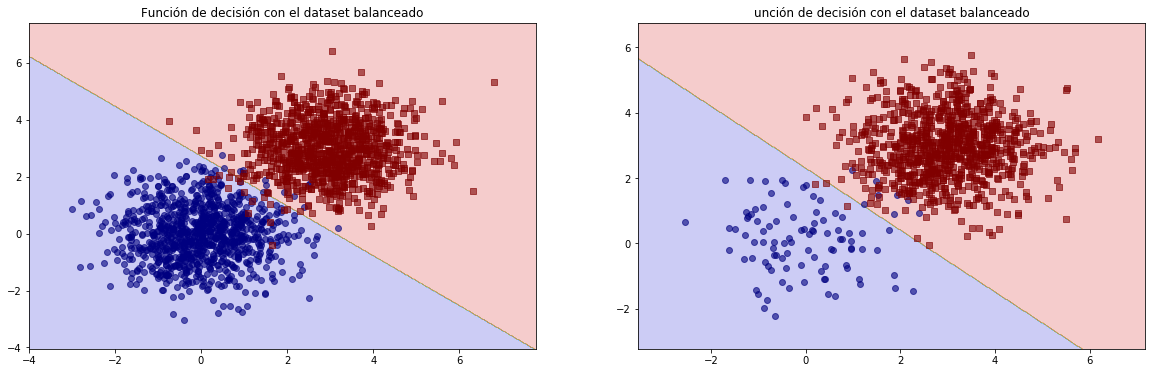

In [5]:
#Visualizamos las fronteras de decisión de ambos clasificadores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

plot_decision_function(X_blc, y_blc, clc_blc, ax1)
ax1.set_title('Función de decisión con el dataset balanceado')

plot_decision_function(X_des, y_des, clc_des, ax2)
ax2.set_title('unción de decisión con el dataset balanceado')

Si se observa cuidadosamente, vemos que el clasificador de la derecha (el entrenado con el conjunto de datos desbalanceado) empuja la frontera de decisión hacia la clase mayoritaria, lo que evidencia el sesgo del mismo por el desbalace de las clases, comparado con el clasificador que se ha entrenado con el conjunto balanceado (el de la izquierda).

## 2. Técnicas de Muestreo Aleatorio

Estas técnicas modifican la distribución de las clases con el fin de disminuir el grado de desbalace que hay entre las clases. Para ver el resultado de estas técnicas vamos a trabajar con un conjunto de datos diferente en el que hay 3 clases con 3 formas diferentes y  outliers incluídas en la misma.

Text(0.5,1,'Distribución de los datos en X2')

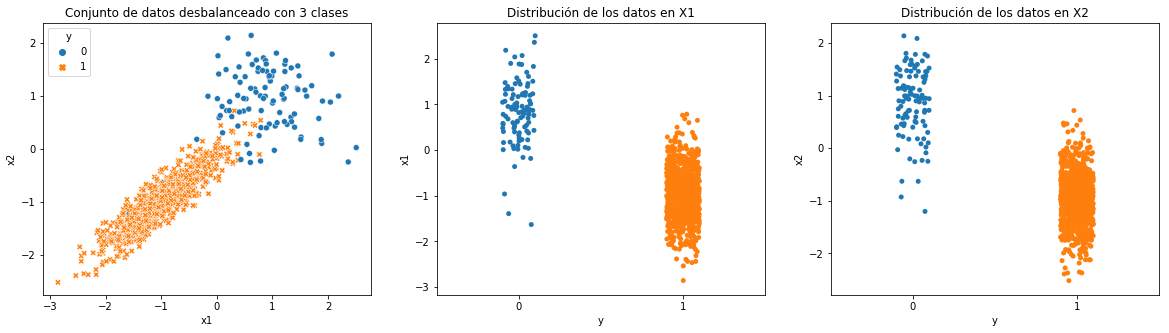

In [6]:
#Generamos el conjunto de datos de 3 clases.
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.1, 0.9],
                           class_sep=1, random_state=34)

#Creamos un DataFrame a partir del conjunto de datos, para visualizarlo
df = pd.DataFrame(data=X, columns=["x1", "x2"])
df['y'] = y

#Visualizamos el conjunto de datos y la distrubución de los mismos en cada eje
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="tab10", style="y", ax=ax1)
ax1.set_title('Conjunto de datos desbalanceado con 3 clases')

sns.stripplot(x="y", y="x1", data=df, palette="tab10", ax=ax2)
ax2.set_title('Distribución de los datos en X1')

sns.stripplot(x="y", y="x2", data=df, palette="tab10", ax=ax3)
ax3.set_title('Distribución de los datos en X2')

### 2.1 SubMuestreo Aleatorio

En el submuestreo aleatorio se seleccionan de manera aleatoria, tantas instancias de la clase mayoritaria como tenga la clase minoritaria. Esto hace que el cojunto de datos se reduzca, con base en el tamaño de la clase con menos datos. Usemos la biblioteca imblearn para aplicar este método de muestreo y veamos como cambia el número de muestras y la distribución de las clases.

In [7]:
from imblearn.under_sampling import RandomUnderSampler

#El método para realizar la selección aleatoria es RUS - RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

#Imprimimos el núemro de instancias en cada clase
print ("Conjunto Original:\n\tClase 0: ",np.sum(y==0), 
                          "\n\tClase 1: ",np.sum(y==1))
print ("\nConjunto Modificado:\n\tClase 0: ",np.sum(y_rus==0), 
                           "\n\tClase 1: ",np.sum(y_rus==1))

Conjunto Original:
	Clase 0:  104 
	Clase 1:  896

Conjunto Modificado:
	Clase 0:  104 
	Clase 1:  104


Text(0.5,1,'Conjunto de datos balanceado con RUS')

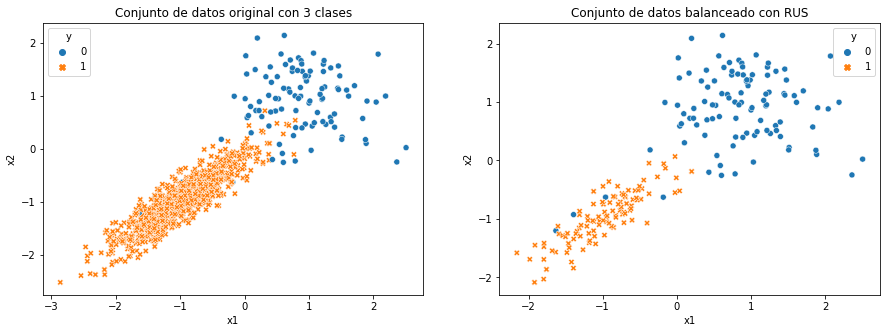

In [8]:
#Creamos un DataFrame a partir del conjunto de datos, para visualizarlo
df_rus = pd.DataFrame(data=X_rus, columns=["x1", "x2"])
df_rus['y'] = y_rus


#Visualizamos ambos conjuntos de datos, el original y el balanceado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="tab10", ax=ax1)
ax1.set_title('Conjunto de datos original con 3 clases')

sns.scatterplot(data=df_rus, x="x1", y="x2", hue="y", style="y", palette="tab10", ax=ax2)
ax2.set_title('Conjunto de datos balanceado con RUS')

Ahora entremos un clasificador con ambos conjuntos de datos y veamos la diferencia entre las fronteras de decisión.

In [9]:
#Se entrenan los clasificadores con los dos conjuntos de datos
clc0 = LinearSVC()
clc1 = LinearSVC()

clc0.fit(X,y)
clc1.fit(X_rus,y_rus)

LinearSVC()

Text(0.5,1,'Función de decisión con el SubMuestreo Aleatorio')

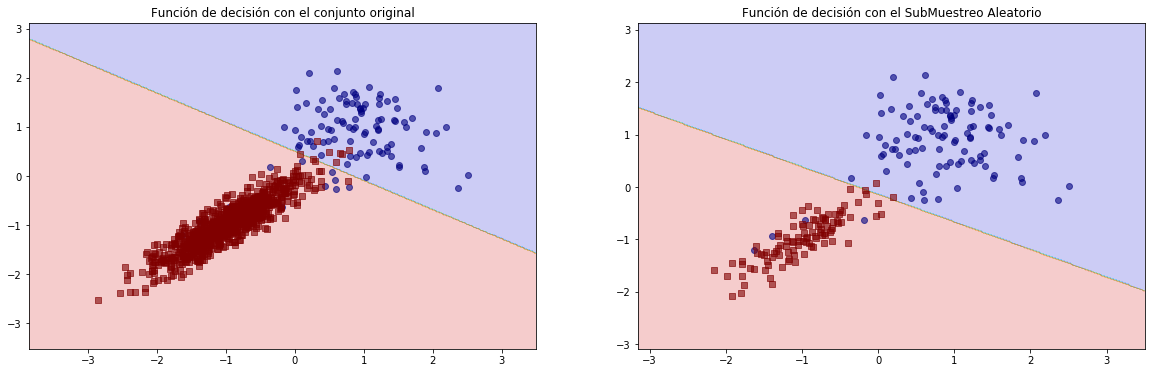

In [10]:
#Visualizamos las fronteras de decisión de ambos clasificadores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con el conjunto original')

plot_decision_function(X_rus, y_rus, clc1, ax2)
ax2.set_title('Función de decisión con el SubMuestreo Aleatorio')

### 2.2 SobreMuestreo Aleatorio

En el sobremuestreo aleatorio las instancias de la clase minoritaria se replican de manera aleatoria hasta alcanzar el número de instancas de la clase mayoritaria. Esto hace que el cojunto de datos aumente su tamaño. Usemos la biblioteca imblearn para aplicar este método de muestreo y veamos como cambia el número de instancias y la distribución de las clases.

In [11]:
from imblearn.over_sampling import RandomOverSampler

#El método para realizar la selección aleatoria es ROS - RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

Text(0.5,1,'Conjunto de datos balanceado con ROS')

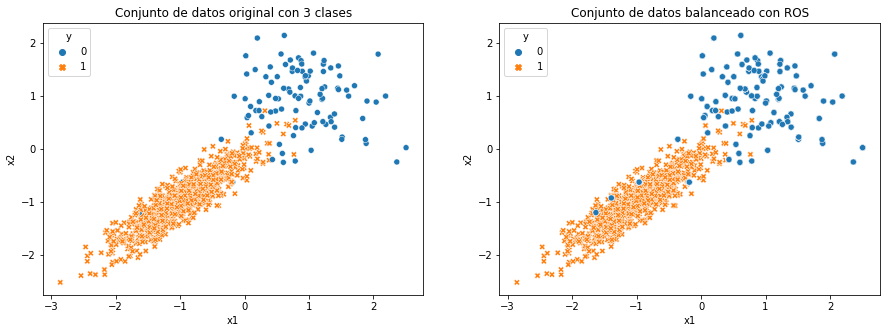

In [12]:
#Creamos un DataFrame a partir del conjunto de datos, para visualizarlo
df_ros = pd.DataFrame(data=X_ros, columns=["x1", "x2"])
df_ros['y'] = y_ros

#Visualizamos ambos conjuntos de datos, el original y el balanceado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", style="y", palette="tab10", ax=ax1)
ax1.set_title('Conjunto de datos original con 3 clases')

sns.scatterplot(data=df_ros, x="x1", y="x2", hue="y", style="y", palette="tab10", ax=ax2)
ax2.set_title('Conjunto de datos balanceado con ROS')

¿Qué nota de particular en ambos conjuntos de datos? Veámos cuántas instancias hay en cada clase en conjunto balanceado:

In [14]:
#Imprimimos el núemro de instancias en cada clase
print ("Conjunto Original:\n\tClase 0: ",np.sum(y==0), 
                          "\n\tClase 1: ",np.sum(y==1))
print ("Conjunto Modificado:\n\tClase 0: ",np.sum(y_ros==0), 
                           "\n\tClase 1: ",np.sum(y_ros==1))

Conjunto Original:
	Clase 0:  104 
	Clase 1:  896
Conjunto Modificado:
	Clase 0:  896 
	Clase 1:  896


Ahora entrenemos un clasificador y veámos como cambian las fronteras de decisión

Text(0.5,1,'Función de decisión con el SobreMuestreo Aleatorio')

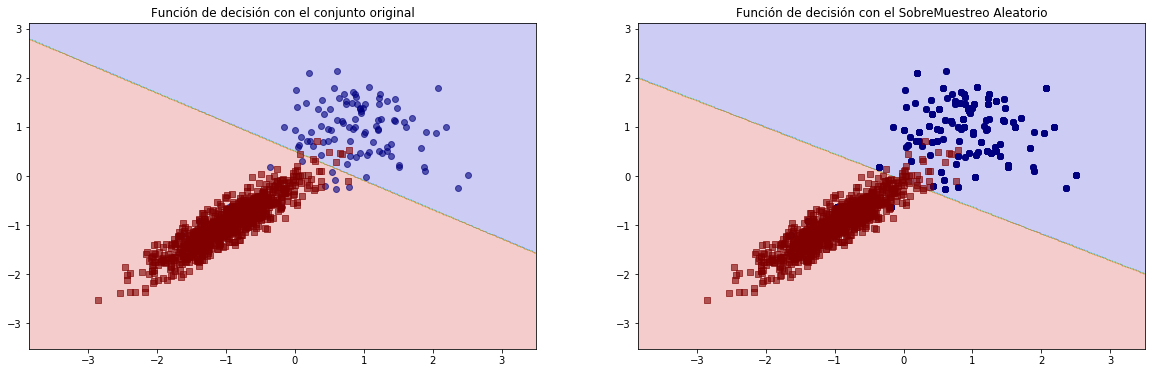

In [15]:
#Entreno el clasificador con el conjunto balanceado
clc1.fit(X_ros,y_ros)

#Visualizamos las fronteras de decisión de ambos clasificadores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con el conjunto original')

plot_decision_function(X_ros, y_ros, clc1, ax2)
ax2.set_title('Función de decisión con el SobreMuestreo Aleatorio')

## 3. Técnicas de Muestreo Informado

Este tipo de tecnicas buscan equilibrar el número de instancias en las clases, eliminando instancias retiradas de la frontera de decisión o instancias en la frontera de decisión que dfificulan al algoritmo de clasificación establece una separación adecuada de las clases.

### 3.1 Técnicas de SubMuestreo Informado

### 3.1.1 CNN - Condensed Nearest Neighbour

Este algoritmo utiliza el clasificador kNN (con k=1) para decidir, iterativamente, si una instancia debe mantenerse en el conjunto de datos o no. Su problema es que es sensible al ruido puesto que preservar las instancias ruidosas.

In [17]:
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)

print ("Conjunto con CNN:\n\tClase 0: ",np.sum(y_cnn==0), 
                          "\n\tClase 1: ",np.sum(y_cnn==1))

Conjunto con CNN:
	Clase 0:  104 
	Clase 1:  45


### 3.1.2 Tomek Links

Tomek Links establece enlaces entre pares de instancias muy cercanas, pero de clases opuestas. El algoritmo elimina las instancias de la clase mayoritaria en el enlace lo que conlleva a que se aumente el espacio que separa las dos clases, lo que a su vez facilita el proceso de clasificación.

In [19]:
from imblearn.under_sampling import TomekLinks   
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X, y)

print ("Conjunto con TL:\n\tClase 0: ",np.sum(y_tl==0), 
                          "\n\tClase 1: ",np.sum(y_tl==1))

Conjunto con TL:
	Clase 0:  104 
	Clase 1:  890


### 3.1.3 OSS - One Sided Selection 

Este algoritmo es una composición entre CNN y TomekLinks para eliminar las instancias consideradas ruidosas en la clase mayoritaria.

In [20]:
from imblearn.under_sampling import OneSidedSelection   
oss = OneSidedSelection()
X_oss, y_oss = oss.fit_resample(X, y)

print ("Conjunto con OSS:\n\tClase 0: ",np.sum(y_oss==0), 
                          "\n\tClase 1: ",np.sum(y_oss==1))

Conjunto con OSS:
	Clase 0:  104 
	Clase 1:  805


Ahora usemos los datos balanceados para entrenar diferentes clasificadores:

In [22]:
#Clasificador entrenado con los datos obtenidos de CNN
clc1 = LinearSVC()
clc1.fit(X_cnn, y_cnn)

#Clasificador entrenado con los datos obtenidos de Tomek Links
clc2 = LinearSVC()
clc2.fit(X_tl, y_tl)

#Clasificador entrenado con los datos obtenidos de OSS
clc3 = LinearSVC()
clc3.fit(X_oss, y_oss)

LinearSVC()

Visualizemos esos clasificadores:

Text(0.5,1,'Función de decisión con SubMuestreo OSS')

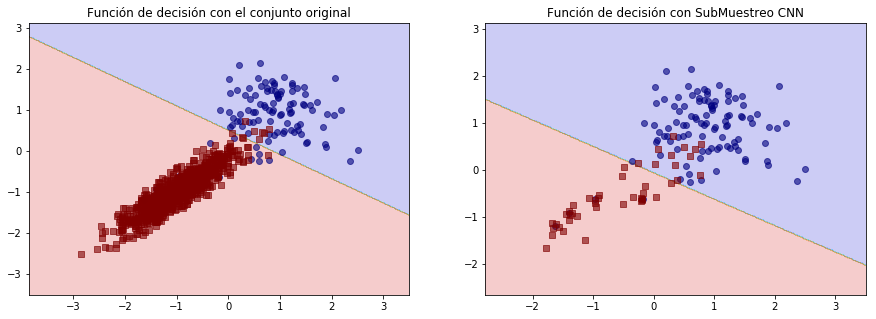

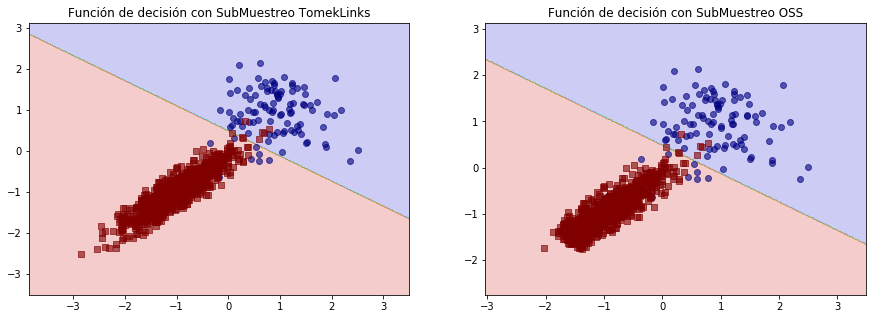

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con el conjunto original')

plot_decision_function(X_cnn, y_cnn, clc1, ax2)
ax2.set_title('Función de decisión con SubMuestreo CNN')

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15,5))

plot_decision_function(X_tl, y_tl, clc2, ax3)
ax3.set_title('Función de decisión con SubMuestreo TomekLinks')

plot_decision_function(X_oss, y_oss, clc3, ax4)
ax4.set_title('Función de decisión con SubMuestreo OSS')

### 3.1.4 Instance Hardness Threshold

Este método utiliza la predicción de un clasificador basado en probabilidades para eliminar, de la clase mayoritaria aquellas instancias que se clasifican con una probabilidad baja.

In [24]:
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.linear_model import LogisticRegression

iht = InstanceHardnessThreshold(random_state=0, estimator=LogisticRegression(solver='lbfgs'))
X_iht, y_iht = iht.fit_resample(X, y)

print ("Conjunto con IHT:\n\tClase 0: ",np.sum(y_iht==0), 
                          "\n\tClase 1: ",np.sum(y_iht==1))

Conjunto con IHT:
	Clase 0:  104 
	Clase 1:  104


In [25]:
clc4 = LinearSVC()
clc4.fit(X_iht, y_iht)

LinearSVC()

Text(0.5,1,'Función de decisión con SubMuestreo con IHT')

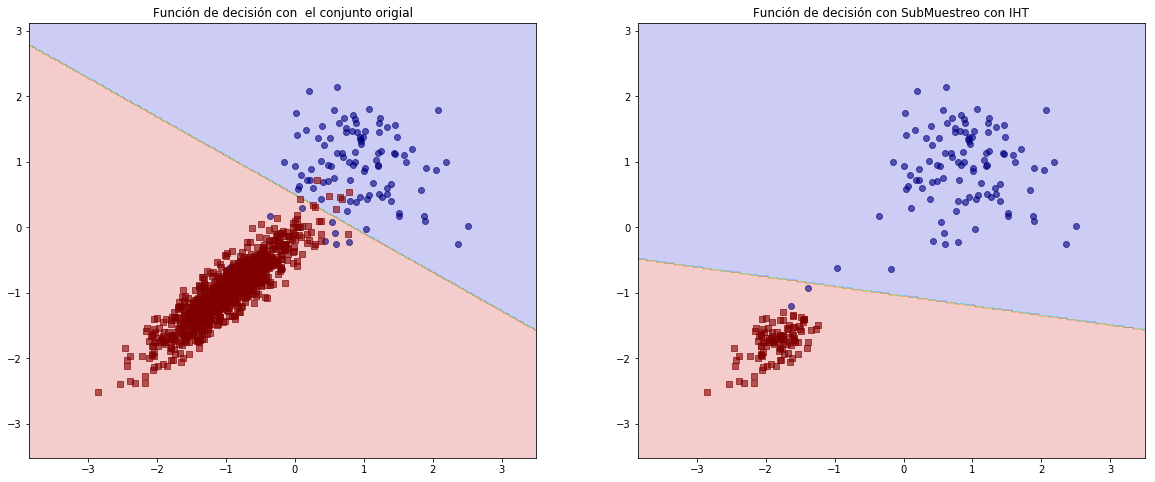

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con  el conjunto origial')

plot_decision_function(X_iht, y_iht, clc4, ax2)
ax2.set_title('Función de decisión con SubMuestreo con IHT')


### 3.2 Técnicas de SobreMuestreo Informado

El principio de estas técnicas es aumentar el número de instancias en la clase minoritaria creando instancias artificiales que ayuden a definir mejor la frontera de decisión entre las dos clases.

### 3.2.1 SMOTE

A diferencia del sobremuestre aleatorio que repite las mismas muestras una y otra vez hasta alcanzar el número de instancias de la clase mayoritaria, SMOTE utiliza una heurística muy sencilla: crea instancias sintéticas en un punto aleatorio entre la línea recta que une a dos puntos de la misma clase en el conjunto de datos.

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X, y)

print ("Conjunto con IHT:\n\tClase 0: ",np.sum(y_smote==0), 
                          "\n\tClase 1: ",np.sum(y_smote==1))

Conjunto con IHT:
	Clase 0:  896 
	Clase 1:  896


Text(0.5,1,'Función de decisión con SMOTE')

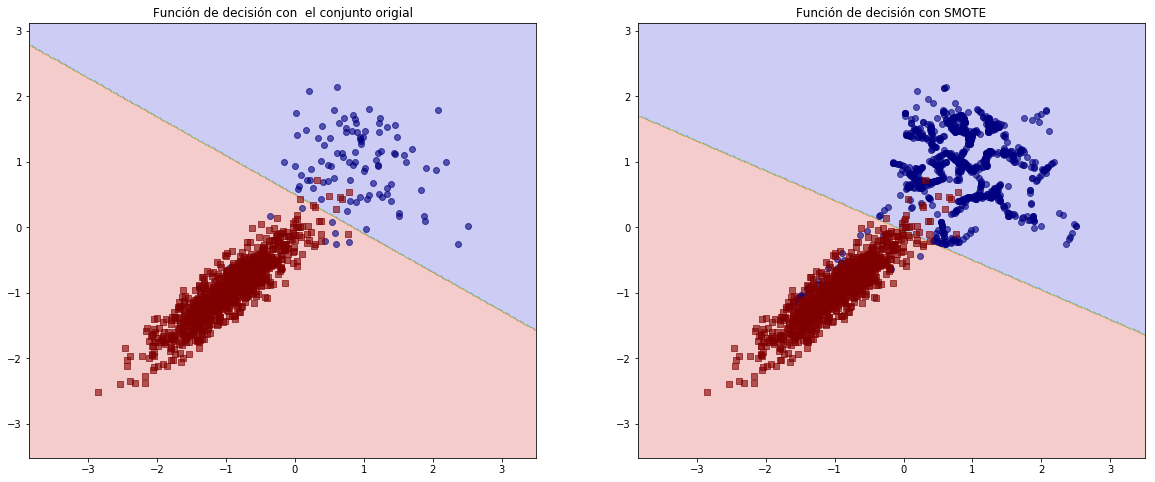

In [28]:
#Entrenemos un clasificador
clc1.fit(X_smote, y_smote)

#Garfiquemos las fronteras de decisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con  el conjunto origial')

plot_decision_function(X_smote, y_smote, clc1, ax2)
ax2.set_title('Función de decisión con SMOTE')

### 3.2.2 ADASYN

Es una variante de SMOTE que trata de identificar cuáles son los puntos de la clase minoritaria que tienen problemas en clasificarse como tal, usando un clasificador kNN. Una vez identificados esos puntos, se utiliza SMOTE ara crear las instancias sintéticas, pero usando como base los puntos identificados como difíciles de clasificar.

In [29]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=0)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

Text(0.5,1,'Función de decisión con ADASYN')

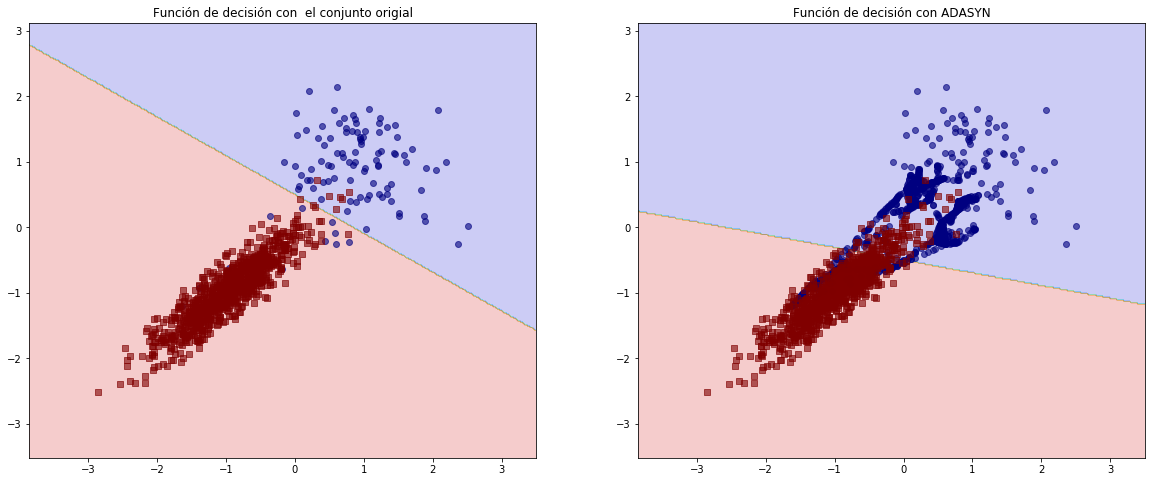

In [30]:
#Entrenemos un clasificador
clc2.fit(X_adasyn, y_adasyn)

#Garfiquemos las fronteras de decisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con  el conjunto origial')

plot_decision_function(X_adasyn, y_adasyn, clc2, ax2)
ax2.set_title('Función de decisión con ADASYN')

### 3.2.2 BoderlineSMOTE

Esta es otra variante de SMOTE la cual trata de identificar los puntos de la clase minoritaria que están en la frontera de decisión para crear las instancias sintéticas a partir de estos.

In [31]:
from imblearn.over_sampling import BorderlineSMOTE

border = BorderlineSMOTE(random_state=0)
X_border, y_border = border.fit_resample(X, y)

Text(0.5,1,'Función de decisión con ADASYN')

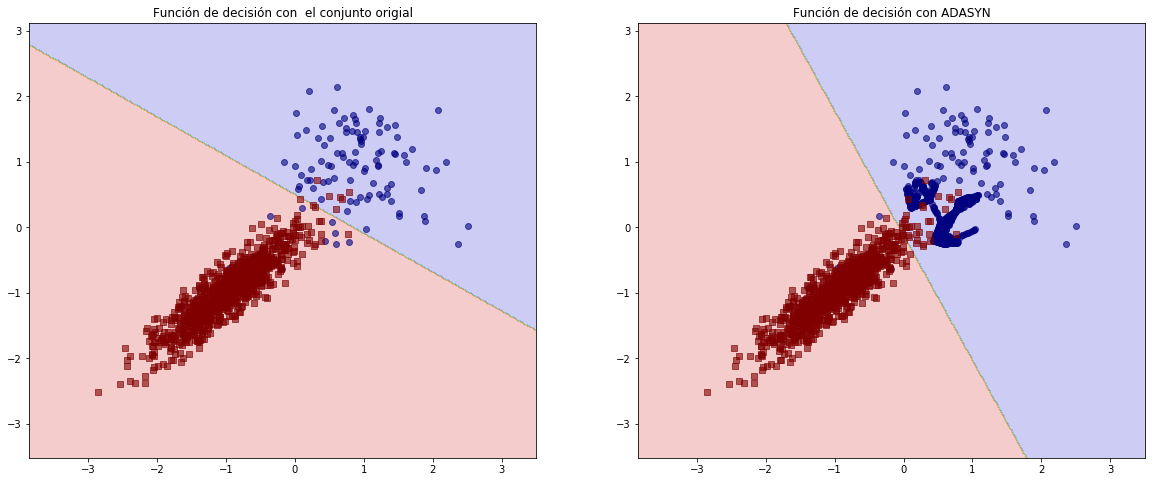

In [32]:
#Entrenemos un clasificador
clc3.fit(X_border, y_border)

#Garfiquemos las fronteras de decisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con  el conjunto origial')

plot_decision_function(X_border, y_border, clc3, ax2)
ax2.set_title('Función de decisión con ADASYN')

## 4. Métodos Basados en Ensambles

Como se mostró, los métodos de submuestreo implican eliminar instancias de la clase mayoritaria y en ese proceso se pueden perder instancias importantes para definir la frontera de decisión de esa clase. Una alternativa a los métodos de submuestreo es el uso de métodos basados en ensambles de clasificadores los cuales pueden entrenar diferentes clasificadores con distintas muestras de la clase mayoritaria y definir, por consenso, la clase de un nuevo dato a clasificar.

Veamos algunos de estos métodos.

### 4.1 Easy Ensamble

Crea subconjuntos  de datos aleatorios de la clase mayoritaria que tengan el tamaño de la clase minoritaria. Con cada subconjunto entrene un clasificador y combine sus salidas usando voto mayoritario.

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier

eec = EasyEnsembleClassifier(random_state=42)
eec.fit(X, y) # doctest: +ELLIPSIS

In [ ]:
#Garfiquemos las fronteras de decisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

plot_decision_function(X, y, clc0, ax1)
ax1.set_title('Función de decisión con  el conjunto origial')

plot_decision_function(X, y, eec, ax2)
ax2.set_title('Función de decisión con EasyEnsamble')

### 4.2 Versiones para aprendizaje balanceado de algoritmos basados en ensambles

Se ha demostrado que los clasificadores basados en esambles mejoran el desempeño en comparación con un clasificador único. Sin embargo, se debe tener presente que estos también se ven afectados por el desbalance entre las clases. 

Veamos como cambia el rendimiento de un clasificador basado en esambles, comparado con versión para clases desbalanceadas. 

In [ ]:
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split

#Cargamos un conjunto de datos SatImage de UCI que esté entre los cnjuntos de datos de imblearn
satimage = fetch_datasets()['satimage']
X, y = satimage.data, satimage.target

#Particionamos el conjunto de datos en partes: training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

#Exploramos como está compuesto el conjunto de datos, por lo que creamos un DataFrame
df = pd.DataFrame(X_train)
df['y'] = y_train

df.describe()

Iniciemos entrenando un clasificador tradicional: un árbol de decisión.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Entrenamos un árbol  de decisión
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

#Evaluamos con el conjunto de test
y_pred = tree.predict(X_test)

#Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print("Matriz de Confusión: \n", cm)
print("\n\nReporte de clasificación: \n", classification_report(y_test, y_pred))

Ahora en lugar de usar un solo árbol de desición usemos un ensamble de árboles entrenados con una estrategia de Bagging. Vamos a usar dos versiones: una  es el Bagging tradicional y otra es el Bagging para conjuntos desbalanceados, el cual hace un sub-muestreo aleatorio de la clase mayoritaria para balancear cada clasificador del Bagging. 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

bagging = BaggingClassifier(n_estimators=20, random_state=0, n_jobs=-1)
balanced_bagging = BalancedBaggingClassifier(n_estimators=20, random_state=0, n_jobs=-1)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bg = bagging.predict(X_test)
y_pred_bbg = balanced_bagging.predict(X_test)

#Mostramos la matriz de confusión
print("Matriz de Confusión de la Estrategia de Bagging: \n", confusion_matrix(y_test, y_pred_bg))
print("\n\nMatriz de Confusión de la Estrategia de Bagging Balanceado: \n", confusion_matrix(y_test, y_pred_bbg))

Ahora hagamos la misma prueba con los ensambles basados en Boosting.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier(n_estimators=20)

eec = EasyEnsembleClassifier(n_estimators=20,
                             base_estimator=DecisionTreeClassifier(),
                             n_jobs=-1)

ada_boost.fit(X_train, y_train)
eec.fit(X_train, y_train)

y_pred_ada = ada_boost.predict(X_test)
y_pred_eec = eec.predict(X_test)

#Mostramos la matriz de confusión
print("Matriz de Confusión de AdaBoost: \n", confusion_matrix(y_test, y_pred_ada))
print("\n\nMatriz de Confusión de EasyEnsamble: \n", confusion_matrix(y_test, y_pred_eec))

## 5. Un Ejercicio Práctico

Ahora que ya conoces el problema que implica entrenar un clasificador con un conjunto de datos desbalanceado y algunas formas para abordar este problema, pues es hora de que pongas en práctica estos conocimientos con un conjunto de la vida real.

La idea es trabajar sobre uno de los conjuntos de datos de una de las competencias de kaggel: Porto Seguros. Esta es la descripción del problema:

Nada arruina más rápido la emoción de comprar un auto nuevo que ver la factura del seguro todo riesgo del mismo. Esto es aún más doloroso cuando sabes que eres un buen conductor. No nos parece justo que tengamos que pagar tanto si siempre hemos sido conductores cautelosos durante años.

Porto Seguro, una de las mayores aseguradoras de automóviles y viviendas de Brasil, está completamente de acuerdo con esto. Las imprecisiones en las predicciones de reclamaciones de las compañías de seguros de automóviles aumentan el costo del seguro para los buenos conductores y reducen el precio para los malos.

Así que ahora tu tienes el desafío de entrenar un modelo que prediga la probabilidad de que un conductor haga uso de  su seguro de automóvil en el próximo año. 

Este conjunto de datos tiene 58 características y está divido en dos partes: una para entrenar y otra para hacer la validación de los modelos.


Elementos a desarrollar:

- Cargue los conjuntos de datos como conjuntos de datos de pandas (DataFrames)
- Determine cuál es el grado de desbalance entre las clases
- Entrene un modelo de clasificación (ojalá uno medianamente robusto) y calcule la precisión (accuracy) del modelo sobre el conjunto de prueba. ¿Solo con base en esta métrica, puede considerarse que el modelo es bueno?
- Calcule y muestre la matriz de confusión. ¿Sigue pensando que el modelo anterior es bueno?
- Utilice los métodos de muestreo aleatorio y vuelva entrenar el modelo seleccionado y evalúe las matrices de confusión. ¿Cuál es su percepción? ¿Mejoró el desempeño del modelo con alguna de estas estrategias?
- Entre los métodos de submuestreo informado, use Condensed Nearest Neighbour e Instance Hardness Threshold. Calcule las matrices de confusión y analice si hay una mejora en el desempeño de los modelos.
- Entre los métodos de sobremuestreo informado, use SMOTE y BorderlineSMOTE. Calcule las matrices de confusión y analice si hay una mejora en el desempeño de los modelos.
- Entrene un clasificador RandomForest (de sklearn) y compare el resultado con la versión balanceada de ese modelo en imblearn. ¿Hay alguna mejora en los modelos?
- Finalmente, ¿cuál es su conclusión sobre el ejercicio?
